# Simple Example for Bayesian Parameter Estimation
We are going to show how to implement MCMC for a simple example: determining whether a coin is fair

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

Configuration parameters

In [2]:
actual_theta = 0.76
n_samples = 4

## Problem Statement

Our goal is to determine whether a coin is fair by using Bayesian statistics to evaluate some experimental evidence. 

Bayesian methods are built around a process of updating your prior beliefs about a system given evidence about how it performs to form a new "posterior" set of beliefs.

We define these beliefs as models and probability distributions. For example, let's model our coin flipping example as model:

$P(H) = \theta$

where we define the fairness of the coin as a variable, $\theta$.

## Prior distribution

Starting out, we make no assuptions about the fairness of the coin and assume $\theta$ can take on any value between 0 and 1.

We represent this prior belief using a uniform probability distribution and a so-called diffuse prior: $P(\theta) = U(0, 1)$

In [3]:
prior = stats.uniform(0, 1)

Text(0.5, 1.0, 'Prior Distribution')

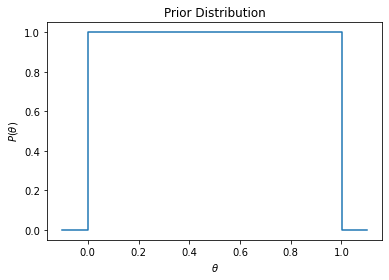

In [4]:
fig, ax = plt.subplots()

x = np.linspace(-0.1, 1.1, 128)
ax.step(x, prior.pdf(x), where='mid')

ax.set_xlabel('$\\theta$')
ax.set_ylabel('$P(\\theta)$')
ax.set_title('Prior Distribution')

## Introducing Bayes's Rule
Bayes's rule lets us update this prior distribution as we gather more data about the problem to form a "posterior" distribution that defines our belief about the parameters after we gather data.

Expressed mathematically, we can write Bayes rule as

$P(\theta|D, M) = \frac{P(D|\theta,M)P(\theta|M)}{P(D|M)}$

where 
- $P(\theta|D, M)$ is our posterior - a function that captures the probability of parameters $\theta$ given our observations ($D$) and chosen model form ($M$).
- $P(D|\theta,M)$ is our likelihood function, the probability of observing data given the model form and choice of parmaeters.
- $P(D|M)$ is evidence, our total probability of observing the data given the chosen model.
- $P(\theta|M)$ is our prior beliefs - what we assumed for the parameters before gathering any data.

## Performing some experiments
Now that we have set up our problem, let's flip a coin many times.

In [5]:
coin = stats.bernoulli(actual_theta)  # Make an engine that flips a heads (1), 60% of the time

In [6]:
samples = coin.rvs(n_samples)
print(f'Flipped the coin {len(samples)} times')

Flipped the coin 4 times


In [7]:
print(f'The coin flipped heads {samples.mean()*100:.1f}% of the time. So, it seems biased but we can be more sure')

The coin flipped heads 75.0% of the time. So, it seems biased but we can be more sure


## Sampling the Posterior
Many analyses you want to perform involve computing properties of the posterior distribution (again, likely distribution of model parameters given your data). 

Solving that distribution (i.e., the function that gives probability as a function of parameters) analytically is rarely possible. But, there are techniques to be able to draw samples from this distribution without knowing its true shape, such as [Markov-Chain Monte Carlo (MCMC) methods](https://www.nature.com/articles/s43586-020-00001-2/tables/1).

Here, we implement a simple one ["Metropolis-Hasting Monte Carlo"](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

This algorithm is as follows:
1. Begin with a point, $\theta$, chosen at random from the prior distribution
2. Generate a new point, $\theta_{new}$ by adding random values to $\theta$.
3. Compute the relative posterior probability of $\theta_{new}$ and $\theta$.
   $r = \frac{P(\theta_{new}|D,M)}{P(\theta|D,M)}=\frac{P(D|\theta_{new},M)P(\theta_{new}|M)}{P(D|\theta,M)P(\theta|M)}$
   
   The second step in that derivation is by applying Bayes's Rule. Note that the evidence term, $P(D|M)$, cancels out
4. Pick a random number ($\beta$) from a uniform distribution between 0 and 1.
5. If $\beta > min(1, r)$, then let $\theta = \theta_{new}$
6. Repeat from 2.

Due to a principle known as "detailed balance" the distribution $\theta$ will be equivalent to the posterior distribution.

Here, we show how to implement this algorithm

### Step 1: Generate a new point
We define a function to generate a new parameter given the previous one. There are few constraints on this function, except that the function should be symmetric. 

In [8]:
def perturb(th):
    return th + np.random.uniform(-0.2, 0.2)
print(f'New random point given 0.5: {perturb(0.5):.2f}')

New random point given 0.5: 0.63


### Step 2: Compute Posterior Probabilities
Our posterior probability has two terms: a likelihood for parameters given data ($P(D|\theta,M)$) and given the prior distribution ($P(\theta,M)$). 

The prior is easy. We defined all points to be equally likely as long as they are between -0.5 and 0.5.

The likelihood is more difficult. Here, we must take the model form - a Bernoulii function - into account. 

See [MathWorld](https://mathworld.wolfram.com/BernoulliDistribution.html) for more details, but we can express the number of heads ($n$) given the number of flips ($N$) observed as a function of the parameter $\theta$ as:

$P(n|\theta,N) = {N \choose n}\theta^n(1-\theta)^{N-n}$

So, we can write the ration between the probabilities as:

$r = \frac{P(D|\theta_{new},M)P(\theta_{new}|M)}{P(D|\theta,M)P(\theta|M)} = \frac{\theta_{new}^n(1-\theta_{new})^{N-n}}{\theta^n(1-\theta)^{N-n}}$



In [9]:
def relative_prob(a, b, n, N):
    """
    Args:
        a - New point
        b - Old point (must be within -0.5 and 0.5)
    Returns:
        Relative probability of a and b
    """
    if a < 0 or a > 1:
        return 0
    return (a ** n) * (1 - a) ** (N - n) / (b ** n * (1 - b) ** (N - n))

In [10]:
relative_prob(0.55, 0.6, samples.sum(), len(samples))

0.8665364583333336

### Step 3: Stringing it together
Make a function that runs the MCMC loop a certain number of times.

In [11]:
def run_mcmc(n_steps):
    """Run MCMC
    
    Args:
        n_steps - Number of steps to run
    """
    
    # Draw a point from the prior distribution
    th = prior.rvs()
    
    # Loop to create new samples
    output = np.zeros(n_steps)
    for i in range(n_steps):
        # Generate a new point
        th_new = perturb(th)
        
        # Get the relative probability
        r = relative_prob(th_new, th, samples.sum(), len(samples))
        
        # Determine if we select the new point
        if np.random.random() < r:
            th = th_new
        
        # Store the point
        output[i] = th
    return output

## Perform the MCMC Sample
We will run a large number of samples to generate statistics about the posterior distribution

In [12]:
post_samples = run_mcmc(32768)

Text(0, 0.5, '$P(\\theta)$')

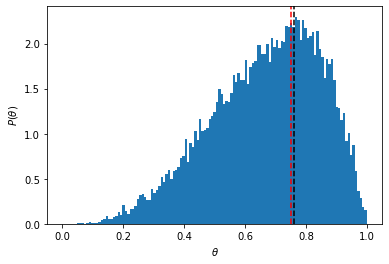

In [13]:
fig, ax = plt.subplots()

ax.hist(post_samples, bins=np.linspace(0, 1, 128), density=True)

# Plot the actual and the mean
ax.set_ylim(ax.get_ylim())
ax.plot([actual_theta]*2, ax.get_ylim(), 'k--')
ax.plot([samples.mean()]*2, ax.get_ylim(), 'r--')

ax.set_xlabel('$\\theta$')
ax.set_ylabel('$P(\\theta)$')

As shown in the above plot, the peak in the distribution is at the observed fraction of heads (red dashed) and the actual value (black dashed) is still within the probability distribution.

Change a few parameters see whether: 
- The distributions moves with the value you choose for the true $\theta$
- More samples makes the distribution converage around the correct value

Metropolis-Hastings Monte Carlo is simple to implement and understand, but has some issues. The samples are strongly-correlated (sampling based on the current position means that the points are not truely-random), it also takes a large number of samples to fully explore the distribution of parameters. These issues are addressed in more advanced MCMC methods, which we will use in the later notebooks. That said, the concept of defining a "likelihood function" to determine how likely a point is and sampling points from the posterior are constant through these methods and are things you can understand with our simpler method.